In [ ]:
%pip install geopy --quiet
%pip install geopandas --quiet
%pip install requests --quiet
%pip install numpy --quiet
%pip intall matplotlib --quiet
%pip install pyvista vtk trame --quiet
%pip install "pyvista[jupyter]" --quiet
%pip install whitebox --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



Usage:   
  e:\Xylem_test\.venv\Scripts\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  e:\Xylem_test\.venv\Scripts\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  e:\Xylem_test\.venv\Scripts\python.exe -m pip install [options] [-e] <vcs project url> ...
  e:\Xylem_test\.venv\Scripts\python.exe -m pip install [options] [-e] <local project path> ...
  e:\Xylem_test\.venv\Scripts\python.exe -m pip install [options] <archive url/path> ...

no such option: --puiet


Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "intall" - maybe you meant "install"



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from geopy.geocoders import Nominatim

def geocode_location(address):
    """
    Given a string like "Dhanmondi, Dhaka", return (lat, lon) in decimal degrees.
    We append ", Bangladesh" so Nominatim knows to look there.
    Returns a tuple (lat, lon) or None if geocoding fails.
    """
    geolocator = Nominatim(user_agent="watergate_app")
    full_address = f"{address}, Bangladesh"
    location = geolocator.geocode(full_address)
    if location is None:
        return None
    return location.latitude, location.longitude


In [2]:
# Test the geocode function
test_address = "Feni River, Feni"     # this has to be dynamically inputted from the front end 
result = geocode_location(test_address)
if result:
    lat, lon = result
    print(f"Geocoded '{test_address}' → lat={lat:.6f}, lon={lon:.6f}")
else:
    print(f"❌ Could not geocode '{test_address}'. Try a different address.")


Geocoded 'Feni River, Feni' → lat=22.831263, lon=91.336773


In [3]:
import numpy as np

def get_bbox(lat, lon):
    """
    Given a (latitude, longitude) in degrees, return a bounding box
    of around 100 km^2 around that point as (west, south, east, north) in degrees.
    """
    # 1) Convert 900 m into degrees at this latitude
    meters_per_deg_lat = 111_000.0
    meters_per_deg_lon = 111_000.0 * np.cos(np.deg2rad(lat))
    delta_deg_lat = 10000.0 / meters_per_deg_lat
    delta_deg_lon = 10000.0 / meters_per_deg_lon

    # 2) Half‐width in each direction
    half_lat = delta_deg_lat / 2.0
    half_lon = delta_deg_lon / 2.0

    # 3) Compute box
    west = lon - half_lon
    east = lon + half_lon
    south = lat - half_lat
    north = lat + half_lat

    return west, south, east, north


lat, lon = result  # reuse from Step 1
w, s, e, n = get_bbox(lat, lon)
print(f"bounding box for ({lat:.6f}, {lon:.6f}):")
print(f"  West = {w:.6f}, South = {s:.6f}")
print(f"  East = {e:.6f}, North = {n:.6f}")
print(f"  Approx. size: {(e-w)*111000:.0f} m × {(n-s)*111000:.0f} m ≈ {(e-w)*111000 * ((n-s)*111000)/1e6:.3f} km²")


bounding box for (22.831263, 91.336773):
  West = 91.287899, South = 22.786218
  East = 91.385648, North = 22.876308
  Approx. size: 10850 m × 10000 m ≈ 108.501 km²


⬇️ Requesting DEM from OpenTopography for box:
   W=91.287899, S=22.786218, E=91.385648, N=22.876308
✅ DEM saved to: dem_user.tif


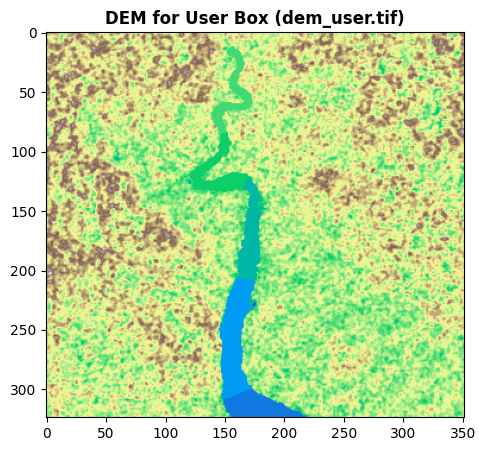

<Figure size 640x480 with 0 Axes>

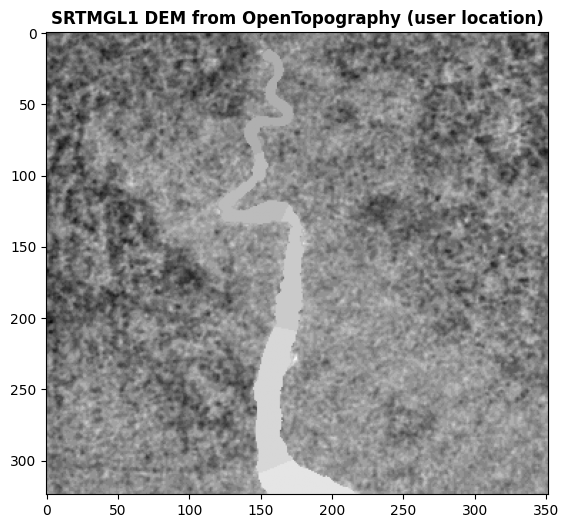

<Axes: title={'center': 'SRTMGL1 DEM from OpenTopography (user location)'}>

In [5]:
import requests
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt


API_KEY = "81ac76541b208f2e3a9a4c24e7bfc6bc"  # <-- our API key, please keep it secret!

def download_dem_opentopo(west, south, east, north, out_tif="dem_user.tif"):
    """
    Download a SRTMGL1 DEM from OpenTopography for the bounding box
    (west, south, east, north) in degrees, save to out_tif.
    """
    # 1) Build the URL
    url = (
          "https://portal.opentopography.org/API/globaldem?"
    f"demtype=SRTMGL1&south={south}&north={north}&west={west}&east={east}"
    f"&outputFormat=GTiff&API_Key={API_KEY}"
    )
    print(f"⬇️ Requesting DEM from OpenTopography for box:\n   W={west:.6f}, S={south:.6f}, E={east:.6f}, N={north:.6f}")
    r = requests.get(url)
    if r.status_code != 200:
        raise RuntimeError(f"Failed to download DEM (HTTP {r.status_code}): {r.text}")

    # 2) Save the content to a GeoTIFF
    with open(out_tif, "wb") as f:
        f.write(r.content)
    print("✅ DEM saved to:", out_tif)

    # 3) Plot the DEM to verify
    with rasterio.open(out_tif) as src:
        arr = src.read(1)
        plt.figure(figsize=(6, 5))
        show(arr, cmap="terrain", title=f"DEM for User Box ({out_tif})")
        plt.tight_layout()
        plt.show()

    return out_tif

# Test it immediately:
west, south, east, north = get_bbox(lat, lon)
dem_path = download_dem_opentopo(west, south, east, north, out_tif="dem_user.tif") # we save out_tif in dem_use.tif file


with rasterio.open("dem_user.tif") as src:
    dem = src.read(1)
    meta = src.profile
plt.figure(figsize=(10, 6))
show(dem, cmap="binary", title="SRTMGL1 DEM from OpenTopography (user location)")


In [5]:
import os
from whitebox import WhiteboxTools

input_dem = r"e:\Xylem_test\dem_user.tif"
filled_dem = r"e:\Xylem_test\filled_dem.tif"
flow_dir = r"e:\Xylem_test\flow_dir.tif"
flow_acc = r"e:\Xylem_test\flow_acc.tif"

print("DEM exists?", os.path.exists(input_dem))

wbt = WhiteboxTools()
wbt.verbose = True     #verbose enables seeing the detailed progress of the tool

wbt.breach_depressions(input_dem, filled_dem)
wbt.d8_pointer(filled_dem, flow_dir)
wbt.d8_flow_accumulation(filled_dem, flow_acc, out_type="cells")

DEM exists? True
.\whitebox_tools.exe --run="BreachDepressions" --dem='e:\Xylem_test\dem_user.tif' --output='e:\Xylem_test\filled_dem.tif' -v --compress_rasters=False

********************************
* Welcome to BreachDepressions *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Pro

0

In [6]:
import numpy as np
import rasterio

STREAM_THRESHOLD = 3000  # you can increase for “only bigger channels”

with rasterio.open("flow_acc.tif") as src:
    flow_acc = src.read(1)

max_acc = np.nanmax(flow_acc)
print(f"Max flow-accumulation in box = {max_acc:.0f} cells")

if max_acc < STREAM_THRESHOLD:
    print("⚠️ No channel found in this 100 km2 -acre box (flow_acc < threshold).")
    # Stop here: do not proceed to watershed or flood.
else:
    print("✅ Channel(s) detected. Proceeding to watershed delineation…")


Max flow-accumulation in box = 66816 cells
✅ Channel(s) detected. Proceeding to watershed delineation…


.\whitebox_tools.exe --run="ExtractStreams" --wd="e:\Xylem_test" --flow_accum='e:\Xylem_test\flow_acc.tif' --output='e:\Xylem_test\streams.tif' --threshold='3000' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress

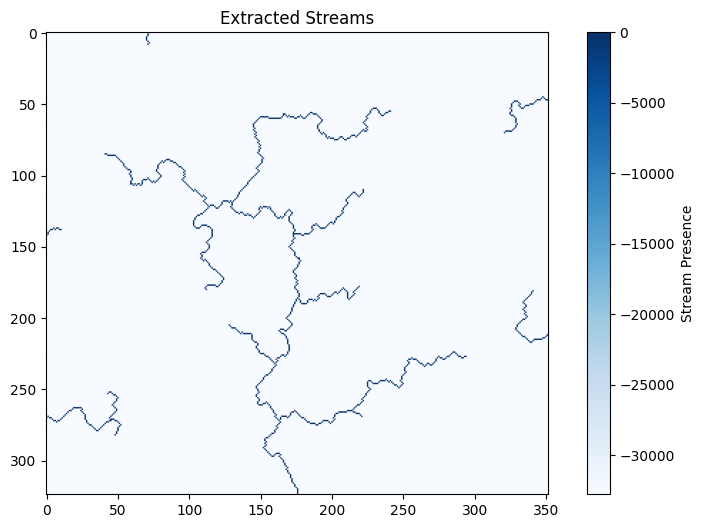

In [7]:
from whitebox import WhiteboxTools
import rasterio
import matplotlib.pyplot as plt

wbt = WhiteboxTools()
wbt.set_working_dir(r"e:\Xylem_test")

flow_acc = r"e:\Xylem_test\flow_acc.tif"
streams = r"e:\Xylem_test\streams.tif"

# Extract streams using a threshold (adjust as needed)
wbt.extract_streams(
    flow_accum=flow_acc,
    output=streams,
    threshold=3000 # Try 500, 1000, or 2000 for different densities
)

# Plot the extracted streams
with rasterio.open(streams) as src:
    streams_data = src.read(1)

plt.figure(figsize=(10, 6))
plt.title("Extracted Streams")
plt.imshow(streams_data, cmap="Blues")
plt.colorbar(label="Stream Presence")
plt.show()


.\whitebox_tools.exe --run="ExtractStreams" --wd="e:\Xylem_test" --flow_accum='e:\Xylem_test\flow_acc.tif' --output='e:\Xylem_test\streams.tif' --threshold='3000' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress

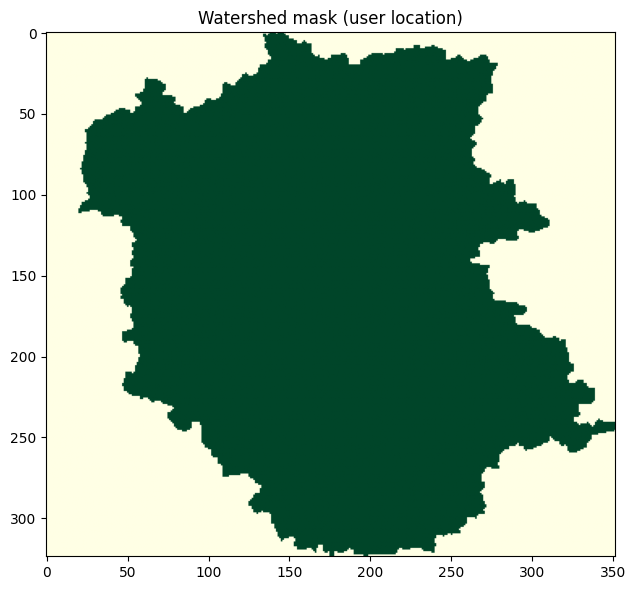

In [8]:
from whitebox import WhiteboxTools
import rasterio
import numpy as np

wbt = WhiteboxTools()
wbt.set_working_dir(r"e:\Xylem_test")


# 1) Extract streams (binary) using our threshold
wbt.extract_streams(
    flow_accum= r"e:\Xylem_test\flow_acc.tif",
    output= r"e:\Xylem_test\streams.tif",
    threshold=STREAM_THRESHOLD
)
print("✔️ Stream network: streams_user.tif")

# 2) Find the row/col of the single "most-accumulation" pixel to use as a pour point
with rasterio.open("flow_acc.tif") as src:
    flow_acc_arr = src.read(1)
    transform = src.transform

# Locate the pixel with maximum flow accumulation
idx_flat = np.nanargmax(flow_acc_arr)
r, c = np.unravel_index(idx_flat, flow_acc_arr.shape)
# Convert r,c to lon/lat:
lon_pp, lat_pp = (
    transform.c + c * transform.a + transform.a/2,
    transform.f + r * transform.e + transform.e/2
)
print(f"Pour point pixel at row {r}, col {c} → lon={lon_pp:.6f}, lat={lat_pp:.6f}")

# 3) Write that pour point to a tiny shapefile
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    pd.DataFrame({'id':[1]}),
    geometry=[Point(lon_pp, lat_pp)],
    crs="EPSG:4326"
)
gdf.to_file("pour_point.shp")
print("✔️ Pour point shapefile: pour_point.shp")

# 4) Snap the pour point to the stream channel (within, say, 10 pixels)
wbt.snap_pour_points(
    pour_pts="pour_point.shp",
    flow_accum="flow_acc.tif",
    output="snapped_pp.shp",
    snap_dist=10
)
print("✔️ Snapped pour point: snapped_pp.shp")

# 5) Delineate watershed
wbt.watershed(
    d8_pntr="flow_dir.tif",
    pour_pts="snapped_pp.shp",
    output="watershed.tif"
)
print("✔️ Watershed: watershed.tif")

# (Optional) Plot the watershed mask
with rasterio.open("watershed.tif") as src:
    ws_user = src.read(1)
    plt.figure(figsize=(10,6))
    plt.imshow(ws_user, cmap="YlGn")
    plt.title("Watershed mask (user location)")
    plt.tight_layout()
    plt.show()


In [9]:
import rasterio

# 1) Open watershed as a raster to get its bounds and transform
with rasterio.open("watershed.tif") as src_ws:
    ws = src_ws.read(1)           # this is a small array already
    ws_transform = src_ws.transform
    ws_crs = src_ws.crs
    # Geographic bounds of the watershed (minx, miny, maxx, maxy)
    ws_bounds = src_ws.bounds     # in the same CRS as the raster (EPSG:4326 likely)

print("Watershed bounds (lon/lat):", ws_bounds)


Watershed bounds (lon/lat): BoundingBox(left=91.28763888892485, bottom=22.786527777772854, right=91.38541666670264, top=22.876527777772864)


In [11]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import numpy as np
from rasterio.warp import reproject, Resampling

# 2) Path to your full ESA WorldCover tile
esa_path = "merged_landcover.tif"

# 3) Open the ESA tile, compute the window that covers the watershed bounds
with rasterio.open(esa_path) as src_lc:
    # Ensure the ESA tile’s CRS matches your watershed’s CRS; likely both are EPSG:4326.
    if src_lc.crs != ws_crs:
        raise RuntimeError("CRS mismatch: reproject waterfall first.")
    
    # Compute the row/col window that covers the watershed bounds
    window = from_bounds(
        ws_bounds.left,
        ws_bounds.bottom,
        ws_bounds.right,
        ws_bounds.top,
        transform=src_lc.transform
    )
    # Round out to integer row/col indices
    window = window.round_offsets().round_shape()
    
    # Read just that window into memory
    lc_window = src_lc.read(1, window=window)
    lc_window_transform = src_lc.window_transform(window)
    lc_meta = src_lc.meta.copy()

# 4) Update metadata to reflect that lc_window is smaller
lc_meta.update({
    "height": lc_window.shape[0],
    "width": lc_window.shape[1],
    "transform": lc_window_transform
})
print("📏 Landcover window shape:", lc_window.shape)

# 5) Define ESA class → runoff coefficient lookup
c_lookup = {
    10: 0.10,  # Tree cover
    20: 0.15,  # Shrubland
    30: 0.20,  # Grassland
    40: 0.30,  # Cropland
    50: 0.85,  # Urban
    60: 0.40,  # Bare / sparse
    70: 0.05,  # Snow / ice
    80: 0.05,  # Water
    90: 0.25,  # Wetlands
    95: 0.10,  # Mangroves
    100: 0.20  # Moss & lichen
}

# 6) Create a small C array the same shape as lc_window
C_window = np.full(lc_window.shape, np.nan, dtype=np.float32)

# 7) Fill C_window based on lookup
for cls_val, c_val in c_lookup.items():
    mask = (lc_window == cls_val)
    C_window[mask] = c_val

# Any pixel in lc_window not in our c_lookup stays NaN (e.g. no-data or unexpected values)


# Prepare an empty array to hold the resampled mask
ws_resampled = np.zeros(lc_window.shape, dtype=np.uint8)

# Reproject (resample) the watershed mask into this new array
reproject(
    source=ws,                           # full-resolution watershed
    destination=ws_resampled,            # this will get high‐res mask
    src_transform=ws_transform,
    dst_transform=lc_window_transform,
    src_crs=ws_crs,
    dst_crs=ws_crs,
    resampling=Resampling.nearest        # nearest neighbor (keeps 1’s as 1’s)
)

print("Shape of resampled watershed mask:", ws_resampled.shape)
# Define your ESA WorldCover → C lookup
c_lookup = {
    10: 0.10,   # Tree cover
    20: 0.15,   # Shrubland
    30: 0.20,   # Grassland
    40: 0.30,   # Cropland
    50: 0.85,   # Urban
    60: 0.40,   # Bare / sparse
    70: 0.05,   # Snow / ice
    80: 0.05,   # Water
    90: 0.25,   # Wetlands
    95: 0.10,   # Mangroves
    100: 0.20   # Moss & lichen
}

# Create C_window with the same shape as lc_window
C_window = np.full_like(lc_window, np.nan, dtype=np.float32)

for cls_val, c_val in c_lookup.items():
    C_window[lc_window == cls_val] = c_val

# Any pixel not in lookup will remain NaN
C_inside = np.where(ws_resampled == 1, C_window, np.nan)

# Compute mean C inside watershed
mean_C = np.nanmean(C_inside)
print(f"🔹 Mean C inside watershed = {mean_C:.3f}")


📏 Landcover window shape: (1080, 1173)
Shape of resampled watershed mask: (1080, 1173)
🔹 Mean C inside watershed = 0.212


e:\Xylem_test\.venv\Lib\site-packages\rasterio\windows.py:729: RasterioDeprecationWarning: round_shape is deprecated and will be removed in Rasterio 2.0.0.
  warnings.warn(


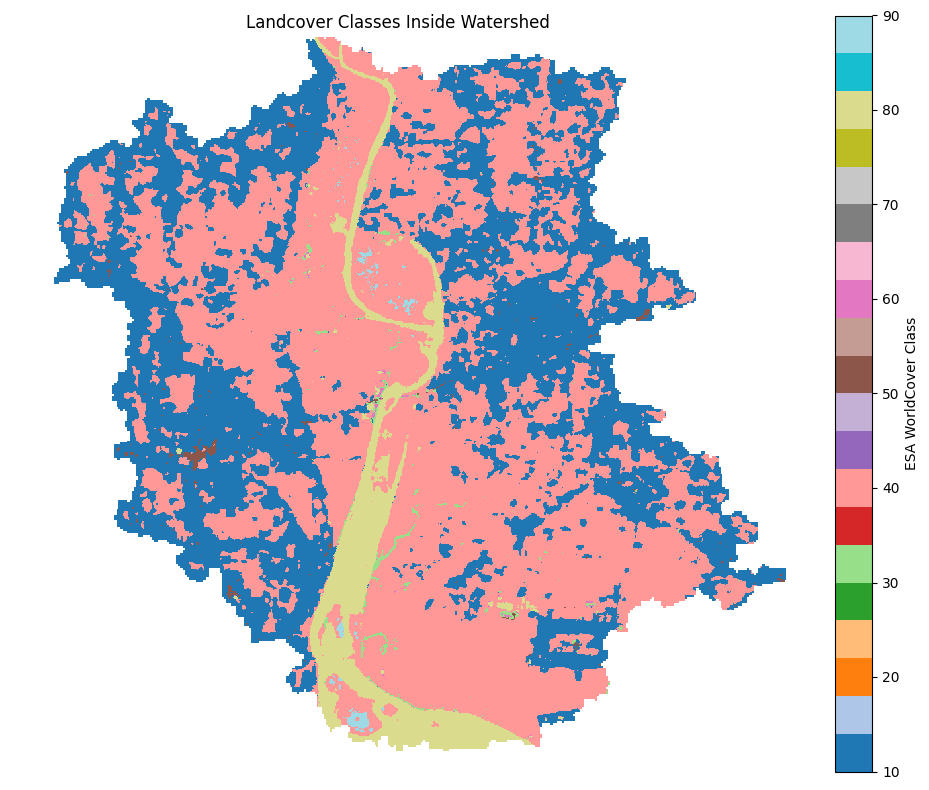

✅ Saved: landcover_in_watershed.tif


In [12]:
# Show only the watershed area from merged_landcover.tif
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Mask the landcover window with the watershed mask
lc_ws = np.where(ws_resampled == 1, lc_window, np.nan)

plt.figure(figsize=(10, 8))
plt.imshow(lc_ws, cmap="tab20", interpolation="none")
plt.title("Landcover Classes Inside Watershed")
plt.axis("off")
plt.colorbar(label="ESA WorldCover Class")
plt.tight_layout()
plt.show()

# Save the masked landcover as a new GeoTIFF
lc_meta.update({
    "dtype": "float32",
    "nodata": np.nan
})
with rasterio.open("landcover_in_watershed.tif", "w", **lc_meta) as dst:
    dst.write(lc_ws, 1)

print("✅ Saved: landcover_in_watershed.tif")

In [13]:
import rasterio

out_meta = lc_meta.copy()
out_meta.update({
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

with rasterio.open("C_inside_watershed.tif", "w", **out_meta) as dst:
    dst.write(C_inside, 1)

print("✅ Saved: C_inside_watershed.tif")


✅ Saved: C_inside_watershed.tif


In [14]:
# Count pixels = 1 inside watershed in the high‐res mask
import numpy as np
num_pixels_inside = np.sum(ws_resampled == 1)

# Each pixel ≈ 10 m × 10 m = 100 m²
pixel_area_m2 = 10 * 10
A_m2 = num_pixels_inside * pixel_area_m2
A_km2 = A_m2 / 1e6
A_acres = A_m2 / 4046.86  # convert m² to acres

print(f"🔹 Watershed area ≈ {A_km2:.3f} km² ({A_m2:.0f} m²)")
print(f"🔹 Watershed area ≈ {A_acres:.3f} acres")


🔹 Watershed area ≈ 74.237 km² (74236800 m²)
🔹 Watershed area ≈ 18344.297 acres


In [15]:
# Given values:
i_inch_hour = 5         # chosen intensity (inches/hour) here we will input rainfall data from turjo's model


# Rational method: Q = C * i * A
Q_feet3_s = mean_C * i_inch_hour * A_acres
print(f"🔹 Peak discharge Q ≈ {Q_feet3_s:.2f} feet3/s")


🔹 Peak discharge Q ≈ 19454.90 feet3/s


Flood depth and inundation mask saved.


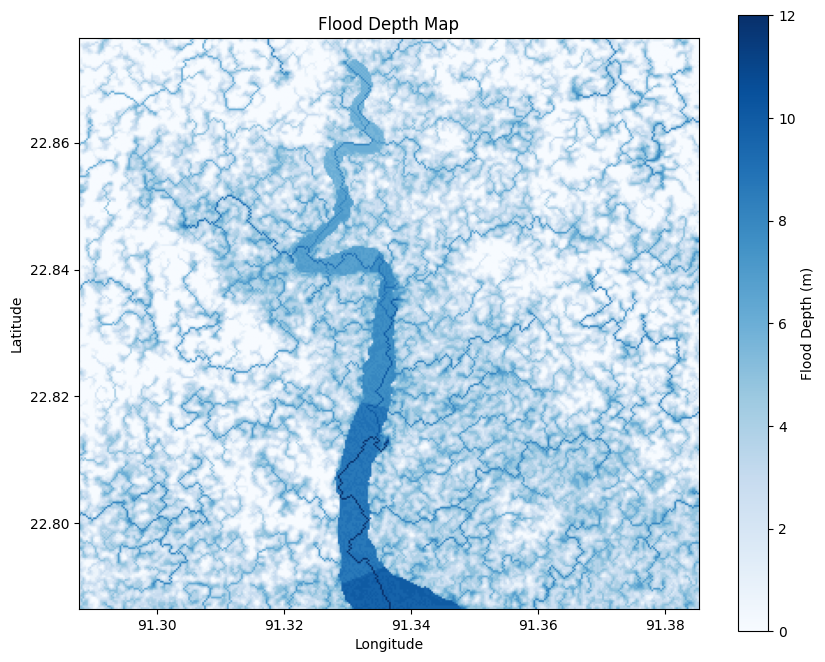

In [16]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

flood_h = 150 #flood time in hours, this is a user input from the front end
# Load the DEM
with rasterio.open("filled_dem.tif") as src:
    dem = src.read(1)  # Elevation data
    transform = src.transform
    profile = src.profile

# Define the total flood volume (in cubic meters)
# Use the previously calculated Q_feet3_s and flood_h
V_total_m3 = Q_feet3_s * flood_h * 3600 * 0.0283168  # Convert ft³ to m³

# Create a water depth array (same shape as the DEM)
water_depth = np.zeros_like(dem, dtype=np.float32)

# Mask invalid DEM values (e.g., nodata)
nodata = src.nodata if src.nodata is not None else -9999
dem = np.where(dem == nodata, np.nan, dem)

# Iteratively "fill" the DEM with water
remaining_volume = V_total_m3
cell_area_m2 = 30 * 30 # DEM from SRTMGL1 is 30m resolution, so each cell is 30m x 30m = 900 m²
while remaining_volume > 0:
    # Find the lowest elevation that is not yet flooded
    min_elevation = np.nanmin(dem + water_depth)
    
    # Calculate the number of cells at this elevation
    flood_cells = (dem + water_depth == min_elevation)
    num_flood_cells = np.sum(flood_cells)
    
    # Calculate the volume required to raise these cells by 1 meter
    volume_per_meter = num_flood_cells * cell_area_m2
    
    # Determine how much water can be added to these cells
    if remaining_volume >= volume_per_meter:
        # Add 1 meter of water to these cells
        water_depth[flood_cells] += 1
        remaining_volume -= volume_per_meter
    else:
        # Add the remaining water evenly to these cells
        water_depth[flood_cells] += remaining_volume / volume_per_meter
        remaining_volume = 0

# Calculate the final flood depth
flood_depth = water_depth

# Create a flood inundation mask (1 = flooded, 0 = not flooded)
inundation_mask = (flood_depth > 0).astype(np.uint8)

# Save the flood depth and inundation mask as GeoTIFFs
flood_depth_profile = profile.copy()
flood_depth_profile.update({
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

with rasterio.open("flood_depth.tif", "w", **flood_depth_profile) as dst:
    dst.write(flood_depth, 1)

inundation_profile = profile.copy()
inundation_profile.update({
    "dtype": "uint8",
    "count": 1,
    "nodata": 0
})

with rasterio.open("flood_inundation_mask.tif", "w", **inundation_profile) as dst:
    dst.write(inundation_mask, 1)

print("Flood depth and inundation mask saved.")

# Visualize the flood depth
plt.figure(figsize=(10, 8))
plt.imshow(flood_depth, cmap="Blues", extent=(transform[2], transform[2] + dem.shape[1] * transform[0],
                                              transform[5] + dem.shape[0] * transform[4], transform[5]))
plt.colorbar(label="Flood Depth (m)")
plt.title("Flood Depth Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [16]:
# Calculate the total flooded area (in square meters and square kilometers)
pixel_area_m2 = 30 * 30  # 30 x 30 meters reslution DEM
flooded_area_m2 = np.sum(inundation_mask) * pixel_area_m2
flooded_area_km2 = flooded_area_m2 / 1e6  # Convert to square kilometers

# Calculate the total flooded volume (in cubic meters)
flooded_volume_m3 = np.nansum(flood_depth * pixel_area_m2)

print(f"🔹 Total Flooded Area: {flooded_area_km2:.2f} km²")
print(f"🔹 Total Flooded Volume: {flooded_volume_m3:.2f} m³")

🔹 Total Flooded Area: 76.22 km²
🔹 Total Flooded Volume: 198324208.00 m³


In [ ]:
from scipy.ndimage import zoom
import pyvista as pv

with rasterio.open('filled_dem.tif') as src:
    dem = src.read(1)  # Read the first band
    transform = src.transform


rows, cols = dem.shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)
z = dem  # Elevation data
pv.set_jupyter_backend('trame')  # Use trame backend for Jupyter


# Create a PyVista grid
grid = pv.StructuredGrid(x, y, dem)
scale_y = dem.shape[0] / flood_depth.shape[0]
scale_x = dem.shape[1] / flood_depth.shape[1]
flood_depth_resized = zoom(flood_depth, (scale_y, scale_x), order=1)  # Bilinear interpolation
force_float=False
print("Resized flood depth shape:", flood_depth_resized.shape)
flood_depth_flattened = flood_depth_resized.ravel()
grid["Flood Depth"] = np.nan_to_num(flood_depth_flattened, nan=0)
flooded_elevation = np.where(flood_depth_resized > 0, dem + flood_depth_resized, np.nan)
grid["Flooded Elevation"] = np.nan_to_num(flooded_elevation.ravel(), nan=dem.ravel())

Resized flood depth shape: (324, 352)


e:\Xylem_test\.venv\Lib\site-packages\pyvista\core\utilities\points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


In [18]:
import pyvista as pv
import numpy as np
import rasterio
from scipy.ndimage import zoom

# Load the DEM
with rasterio.open("filled_dem.tif") as src:
    dem = src.read(1)  # Elevation data
    transform = src.transform

# Load the flood depth
with rasterio.open("flood_depth.tif") as src:
    flood_depth = src.read(1)  # Flood depth data

# Mask invalid DEM values (e.g., nodata)
nodata = src.nodata if src.nodata is not None else -9999
dem = np.where(dem == nodata, np.nan, dem)

# Ensure flood depth matches DEM dimensions
if flood_depth.shape != dem.shape:
    scale_y = dem.shape[0] / flood_depth.shape[0]
    scale_x = dem.shape[1] / flood_depth.shape[1]
    flood_depth_resized = zoom(flood_depth, (scale_y, scale_x), order=1)  # Resample to match DEM
else:
    flood_depth_resized = flood_depth

rows, cols = dem.shape
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)
z = dem  # Elevation data


# Create a PyVista grid
grid = pv.StructuredGrid(x, y, dem)

# Flatten scalars to match the number of points in the grid
flood_depth_flattened = flood_depth_resized.ravel()
flooded_elevation = np.where(flood_depth_resized > 0, dem + flood_depth_resized, np.nan)

# Add the flood depth and flooded elevation as scalar fields
grid["Flood Depth"] = np.nan_to_num(flood_depth_flattened, nan=0)
grid["Flooded Elevation"] = np.nan_to_num(flooded_elevation.ravel(), nan=dem.ravel())

# Create a PyVista plotter
plotter = pv.Plotter()

# Add the terrain surface
plotter.add_mesh(grid, scalars="Flooded Elevation", cmap="terrain", show_edges=False, opacity=0.8)

# Highlight flooded areas
flood_mask = flood_depth_resized > 0
flood_points = np.column_stack((x[flood_mask], y[flood_mask], flooded_elevation[flood_mask]))
flood_cloud = pv.PolyData(flood_points)
plotter.add_mesh(flood_cloud, color="blue", point_size=5, render_points_as_spheres=True, label="Flooded Areas")

# Add legend and labels
plotter.add_legend()
plotter.add_axes()
plotter.show_grid()
plotter.set_background("white")

# Show the interactive plot
plotter.show()

Widget(value='<iframe src="http://localhost:51345/index.html?ui=P_0x2dc607ad790_0&reconnect=auto" class="pyvis…